## Preliminary Research on Wine Reviews Dataset

Source: https://www.kaggle.com/datasets/zynicide/wine-reviews  
The data was scraped from http://www.winemag.com/?s=&drink_type=wine during 2017. 


**Data Description** 
- ```country```: the country of origin of wine
- ```description```: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- ```designation```: the vineyard within the winery where the grapes that made the wine are from
- ```points```: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- ```price```: the cost for a bottle of the wine
- ```province```: the province or state that the wine is from
- ```region_1```: the wine growing area in a province or state (ie Napa)
- ```region_2```: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- ```taster_name```: name of the person who tasted and reviewed the wine
- ```taster_photo```: url of the taster's photo
- ```taster_twitter_handle```: Twitter handle for the person who tasted and reviewed the wine
- ```title```: the title of the wine review
- ```variety```: the type of grapes used to make the wine (ie Pinot Noir)
- ```vintage```: the vintage of the wine
- ```winery```: the winery that made the wine

In this research, I will focus on predicting ratings by puting input variables.

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [3]:
wines2 = pd.read_csv('datasets/winemag-data-130k-v2.csv')
wines2.sample(5)  # breifly check the data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
106836,106836,US,"For the winery's lower-priced offering, this i...",Effort,94,27.0,California,Edna Valley,Central Coast,Matt Kettmann,@mattkettmann,Center of Effort 2014 Effort Pinot Noir (Edna ...,Pinot Noir,Center of Effort
92137,92137,France,93-95. Barrel sample. The wine shows depth and...,Barrel Sample,94,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Clos du Marquis 2011 Barrel Sample (Saint-Jul...,Bordeaux-style Red Blend,Clos du Marquis
42324,42324,France,"This cool, mineral-textured wine has crisp fru...",Les Crays,86,40.0,Burgundy,Pouilly-Fuissé,NaN,Roger Voss,@vossroger,Camille Paquet 2014 Les Crays (Pouilly-Fuissé),Chardonnay,Camille Paquet
82978,82978,US,This medium-bodied wine has more earthy and fl...,NaN,86,10.0,California,California,California Other,Jim Gordon,@gordone_cellars,Leaping Horse 2015 Chardonnay (California),Chardonnay,Leaping Horse
457,457,US,"With a wine this finely constructed, the quest...",Solomon Hills Vineyard,92,45.0,California,Santa Maria Valley,Central Coast,NaN,NaN,Rusack 2011 Solomon Hills Vineyard Pinot Noir ...,Pinot Noir,Rusack


## Data Cleaning

Index column(``Unnamed: 0``) and ``region_2`` is dropped for the simplicity of the dataset.  
To ensure the unique reviews, ``description`` is used to eliminate duplicated values. Also, since we don't want to predict ratings, or recommend wine without the information of price and the variety, ``price``, and ``variety`` are used to drop missing values.

In [4]:
wines2 = wines2.drop('Unnamed: 0', axis=1)  # drop first index column
wines2 = wines2.drop('region_2', axis =1)  # drop 'region_2' column. 
# 'region_2' is indicating more specific regions but most of the times, it is blanked.

In [5]:
# Dropping duplicated and missing values 
wines2 = wines2.drop_duplicates(subset=['description'])
wines2 = wines2.reset_index(drop=True)

wines2 = wines2.dropna(subset=['price', 'variety'])
wines2 = wines2.reset_index(drop=True)

# Descriptive statistics after cleaning
wines2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111566 entries, 0 to 111565
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                111511 non-null  object 
 1   description            111566 non-null  object 
 2   designation            79517 non-null   object 
 3   points                 111566 non-null  int64  
 4   price                  111566 non-null  float64
 5   province               111511 non-null  object 
 6   region_1               93556 non-null   object 
 7   taster_name            88299 non-null   object 
 8   taster_twitter_handle  83816 non-null   object 
 9   title                  111566 non-null  object 
 10  variety                111566 non-null  object 
 11  winery                 111566 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 10.2+ MB


In [6]:
# Check missing data
total = wines2.isnull().sum().sort_values(ascending = False)
percent = (wines2.isnull().sum()/wines2.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
designation,32049,28.726494
taster_twitter_handle,27750,24.873169
taster_name,23267,20.854920
region_1,18010,16.142911
country,55,0.049298
province,55,0.049298
description,0,0.000000
points,0,0.000000
price,0,0.000000
title,0,0.000000


### Regression with CatBoost 

To predict the points(ratings) of wine using given inputs, I will use *boosting*, based on decision tree here. 

Decision tree learning is one of the supervised learning method in ML which predicts results by creating split using the predictors which reduce RSS effectively. Since our output variable, ``points`` is continuous value, regression tree will be appropriate. 


#### Categorical Variables
- Since most of the independent variables are categorical, in order to do regression analysis, we need to transform the categorical features into numerical features. One of the common technique is called one-hot encoding. In this study, we will use CatBoost algorithm which uses one-hot encoding for categorical features automatically. (Ref: https://catboost.ai/en/docs/features/categorical-features) CatBoost builds upon the theory of decision trees and gradient boosting. The main idea of boosting is to sequentially combine many weak models and thus through greedy search create a strong competitive predictive model. 


#### Feature Selection
- To find a most relevant input variables, I will try univariate feature selection based on feature importances from CatboostRegressor. Univariate feature selection works by selecting the best features based on univariate statistical tests. . 

- Since ``description`` needs NLP analysis, I will drop this variable here.

Reference: 
- http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
- https://www.kaggle.com/code/mistrzuniu1/tutorial-eda-feature-selection-regression
- https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329
- https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

In [7]:
wines2 = wines2.drop(columns=['description'])

In [8]:
# Prepare train and test data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import Pool, CatBoostRegressor, cv

X=wines2.drop(columns=['points'])

X=X.fillna(-1)
print(X.columns)
categorical_features_indices =[0,1,3,4,5,6,7,8,9]
y=wines2['points']

# Split data into 80% training and 20% test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=52)

categorical_features_indices

Index(['country', 'designation', 'price', 'province', 'region_1',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


[0, 1, 3, 4, 5, 6, 7, 8, 9]

In [15]:
# Create CatBoostRegressor model with Mean squared error loss function.
def perform_model(X_train, y_train,X_valid, y_valid, X_test, y_test):
    model = CatBoostRegressor(loss_function = 'RMSE', iterations = 300)
    
    # Train model
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # RMSE
    rmse_train = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse_test = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    
    print("R-Squared(train): {:.4f}".format(model.score(X_train, y_train)))
    print("R-Squared(test):  {:.4f}".format(model.score(X_test, y_test)))
    print("RMSE(train): {:.4f}".format(rmse_train))
    print("RMSE(test): {:.4f}".format(rmse_test))

    return model

In [14]:
model=perform_model(X_train, y_train, X_valid, y_valid,X_test, y_test)

R-Squared(training data): 0.6521
R-Squared(test data):  0.5636
RMSE: 1.8299


In [16]:
# Feature importance plotting
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

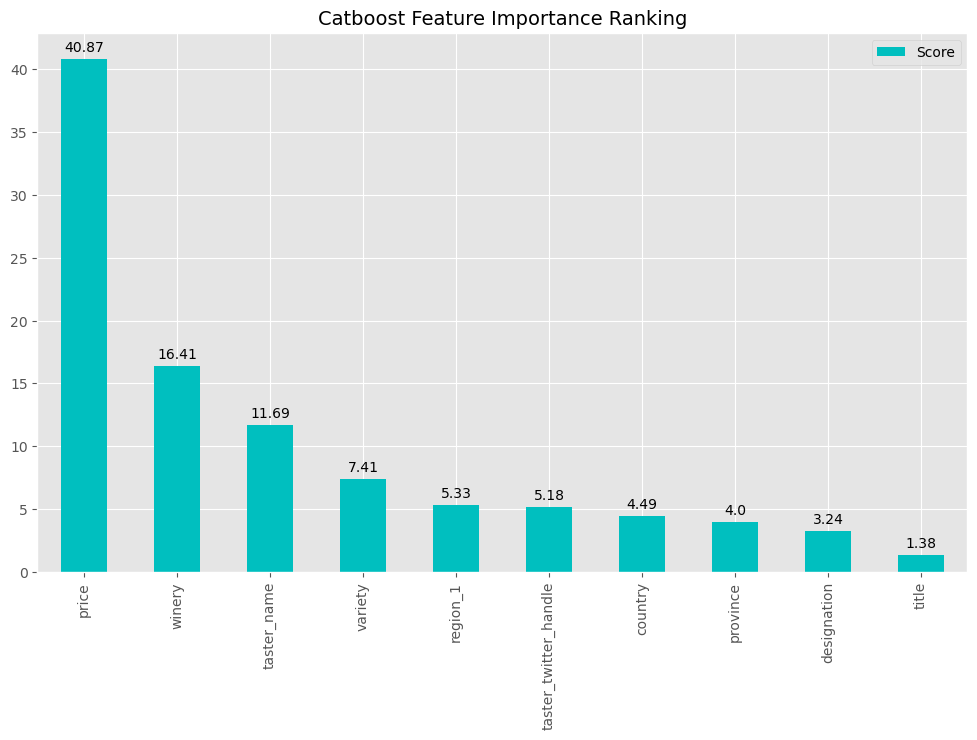

In [17]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

From the Feature importance ranking plot above, we can see that the ``price`` is most important feature in the model, followed by ``winery``, and the ``title`` is the least important feature. 

To simplify our model, let's drop 3 variables with least importance. 

In [21]:
# Now, I will drop 3 varaibles with least importance

X= wines2.drop(columns=['points', 'designation', 'title', 'province'])
X= X.fillna(-1)
y= wines2['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=52)

print(X.columns)
categorical_features_indices =[0,2,3,4,5,6]

Index(['country', 'price', 'region_1', 'taster_name', 'taster_twitter_handle',
       'variety', 'winery'],
      dtype='object')


In [22]:
# Run the model again with less variables
model=perform_model(X_train, y_train, X_valid, y_valid, X_test, y_test)

R-Squared(train): 0.6324
R-Squared(test):  0.5598
RMSE(train): 1.8812
RMSE(test): 2.0572
